In [1]:
%run ./Definitions.ipynb
!nvidia-smi
import os

2019-12-22 20:44:45.830957
thunder  Sun Dec 22 20:44:46 2019
[0] GeForce GTX 1080 Ti | 49'C,  24 % | 10895 / 11178 MB | patra(10885M)
[1] GeForce GTX 1080 Ti | 50'C,  21 % | 10895 / 11178 MB | patra(10885M)
[2] GeForce GTX 1080 Ti | 52'C,  23 % | 10895 / 11178 MB | patra(10885M)
[3] GeForce GTX 1080 Ti | 52'C,   1 % | 10895 / 11178 MB | patra(10885M)
[4] GeForce GTX 1080 Ti | 24'C,   0 % |    10 / 11178 MB |
[5] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |
[6] GeForce GTX 1080 Ti | 30'C,   0 % |    10 / 11178 MB |
[7] GeForce GTX 1080 Ti | 28'C,   0 % |    10 / 11178 MB |


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!

Sun Dec 22 20:45:00 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 35%   49C    P2   211W / 250W |  10895MiB / 11178MiB |     10%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 36%   49C    P2    57W / 250W |  10895Mi

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "4"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K

# config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.Session(config=config)
# K.set_session(sess)

In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling Train set

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
X[Class].value_counts()

0    99455
1     2379
Name: GTu, dtype: int64

In [9]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

#### validation distribution

In [10]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

### Oversampling minority with less imbalance - in train set
Original imbalance ratio **X-** 1:40

Imbalance ratio **up1**-1:5, **up2**-1:10, **up3**-1:20, **up4**-1:30

Balanced ratio **upsampled**-1:1

In [11]:
# upsampling minority
glaucoma_up1 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/5), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up2 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/10), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up3 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/20), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up4 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/30), # match number in majority class
                        random_state=42) # reproducible results

# combine majority and upsampled minority
up1 = pd.concat([not_glaucoma,glaucoma_up1])
up2 = pd.concat([not_glaucoma,glaucoma_up2])
up3 = pd.concat([not_glaucoma,glaucoma_up3])
up4 = pd.concat([not_glaucoma,glaucoma_up4])

# shuffle upsampled dataframe for training
up1 = up1.sample(frac=1)
up2 = up2.sample(frac=1)
up3 = up3.sample(frac=1)
up4 = up4.sample(frac=1)


In [12]:
print("up1")
print(up1[Class].value_counts())
print("up2")
print(up2[Class].value_counts())
print("up1")
print(up3[Class].value_counts())
print("up4")
print(up4[Class].value_counts())

up1
0    99455
1    19891
Name: GTu, dtype: int64
up2
0    99455
1     9945
Name: GTu, dtype: int64
up1
0    99455
1     4972
Name: GTu, dtype: int64
up4
0    99455
1     3315
Name: GTu, dtype: int64


### 2. Class weight

In [13]:
# # Setting class weight for retraining:

# # compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight = [0.5, 2] # experiment with different values
n_NG , n_G

(99455, 2379)

## Define Model and Metrics

In [14]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:78]:
        layer.trainable = False
    for layer in mobile_conv.layers[78:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
 
    # Add new layers
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [15]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    # iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

In [16]:
valid_traindf_names[Class] = valid_traindf_names[Class].astype(int)
valid_valdf_names[Class] = valid_valdf_names[Class].astype(int)

In [17]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True, rescale= 1./255) 
val_datagen = ImageDataGenerator(samplewise_center=True, rescale=1./255)  
BATCH_SIZE = 32

print("\nOriginal imbalanced train data: ")
imb_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = valid_traindf_names, # imbalanced train dataframe
    directory=trainpath,
    x_col=valid_traindf_names.columns[0],
    y_col=valid_traindf_names.columns[which_gt],
#     x_col = upsampled.columns[0], # upsampled data
#     y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nOriginal validation data: ")
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUpsampled train data 1:1 ")
up_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP1 train data 1:5 ")
up1_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up1, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up1.columns[0], # upsampled data
    y_col = up1.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP2 train data 1:10 ")
up2_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up2, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up2.columns[0], # upsampled data
    y_col = up2.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP3 train data 1:20 ")
up3_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up3, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up3.columns[0], # upsampled data
    y_col = up3.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP4 train data 1:30 ")
up4_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up4, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up4.columns[0], # upsampled data
    y_col = up4.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)



Original imbalanced train data: 
Found 101834 validated image filenames.

Original validation data: 
Found 33943 validated image filenames.

Upsampled train data 1:1 
Found 198910 validated image filenames.

UP1 train data 1:5 
Found 119346 validated image filenames.

UP2 train data 1:10 
Found 109400 validated image filenames.

UP3 train data 1:20 
Found 104427 validated image filenames.

UP4 train data 1:30 
Found 102770 validated image filenames.


### Choosing parameters and model compile

In [18]:
which_model = mobilenet_model
# which_model = vgg_model

model = which_model()
learning_rate  = 0.0001 
decay = 1e-5
momentum=0.9
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,589,249
Non-trainable params: 1,640,640
_________________________________________________________________


In [19]:
# With L2 weight regularizer
# es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001, verbose=1)
n_epochs=200
n_steps_per_epoch = 50
n_validation_steps = 10

### Train with upsampled data (1:1)

In [20]:
start = time.time()
up_history = model.fit_generator(up_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/200
50/50 [==============================] - 25s 492ms/step - loss: 0.7413 - Accuracy: 0.5575 - Precision: 0.5785 - Recall: 0.5011 - F1: 0.5030 - AUC: 0.5822 - val_loss: 0.6946 - val_Accuracy: 0.5969 - val_Precision: 0.0460 - val_Recall: 0.4500 - val_F1: 0.0822 - val_AUC: 0.6350
Epoch 2/200
50/50 [==============================] - 22s 431ms/step - loss: 0.6660 - Accuracy: 0.6244 - Precision: 0.6322 - Recall: 0.6421 - F1: 0.6300 - AUC: 0.6621 - val_loss: 0.9235 - val_Accuracy: 0.2219 - val_Precision: 0.0243 - val_Recall: 0.5000 - val_F1: 0.0461 - val_AUC: 0.6796
Epoch 3/200
50/50 [==============================] - 27s 539ms/step - loss: 0.6620 - Accuracy: 0.6263 - Precision: 0.6184 - Recall: 0.6254 - F1: 0.6161 - AUC: 0.6713 - val_loss: 0.6068 - val_Accuracy: 0.6906 - val_Precision: 0.0286 - val_Recall: 0.0667 - val_F1: 0.0400 - val_AUC: 0.7022
Epoch 4/200
50/50 [==============================] - 22s 441ms/step - loss: 0.6474 - Accuracy: 0.6350 - Precision: 0.6366 - Recall: 0.67

Epoch 29/200
50/50 [==============================] - 21s 422ms/step - loss: 0.5494 - Accuracy: 0.7125 - Precision: 0.7067 - Recall: 0.7316 - F1: 0.7122 - AUC: 0.7915 - val_loss: 0.5858 - val_Accuracy: 0.6938 - val_Precision: 0.0319 - val_Recall: 0.1833 - val_F1: 0.0533 - val_AUC: 0.5691
Epoch 30/200
50/50 [==============================] - 24s 489ms/step - loss: 0.5469 - Accuracy: 0.7163 - Precision: 0.7007 - Recall: 0.7488 - F1: 0.7172 - AUC: 0.7957 - val_loss: 0.6178 - val_Accuracy: 0.6562 - val_Precision: 0.0334 - val_Recall: 0.2500 - val_F1: 0.0581 - val_AUC: 0.5683
Epoch 31/200
50/50 [==============================] - 21s 424ms/step - loss: 0.5568 - Accuracy: 0.7181 - Precision: 0.7030 - Recall: 0.7508 - F1: 0.7179 - AUC: 0.7860 - val_loss: 0.5624 - val_Accuracy: 0.6875 - val_Precision: 0.0191 - val_Recall: 0.1500 - val_F1: 0.0333 - val_AUC: 0.5130
Epoch 32/200
50/50 [==============================] - 22s 438ms/step - loss: 0.5387 - Accuracy: 0.7337 - Precision: 0.7544 - Recall: 

50/50 [==============================] - 24s 490ms/step - loss: 0.5476 - Accuracy: 0.7300 - Precision: 0.7486 - Recall: 0.7432 - F1: 0.7386 - AUC: 0.7957 - val_loss: 0.5729 - val_Accuracy: 0.6750 - val_Precision: 0.0874 - val_Recall: 0.5167 - val_F1: 0.1455 - val_AUC: 0.6887
Epoch 58/200
50/50 [==============================] - 21s 423ms/step - loss: 0.5501 - Accuracy: 0.7312 - Precision: 0.7359 - Recall: 0.7489 - F1: 0.7360 - AUC: 0.7970 - val_loss: 0.6754 - val_Accuracy: 0.6375 - val_Precision: 0.0188 - val_Recall: 0.2000 - val_F1: 0.0343 - val_AUC: 0.6190
Epoch 59/200
50/50 [==============================] - 25s 490ms/step - loss: 0.5641 - Accuracy: 0.7269 - Precision: 0.7152 - Recall: 0.7570 - F1: 0.7278 - AUC: 0.7825 - val_loss: 0.7067 - val_Accuracy: 0.6250 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.0890
Epoch 60/200
50/50 [==============================] - 21s 427ms/step - loss: 0.5610 - Accuracy: 0.7063 - Precision: 0.6991 - Recall: 0

50/50 [==============================] - 22s 438ms/step - loss: 0.5416 - Accuracy: 0.7269 - Precision: 0.7356 - Recall: 0.7421 - F1: 0.7269 - AUC: 0.8032 - val_loss: 0.6778 - val_Accuracy: 0.5500 - val_Precision: 0.0717 - val_Recall: 0.6667 - val_F1: 0.1266 - val_AUC: 0.6492
Epoch 86/200
50/50 [==============================] - 25s 505ms/step - loss: 0.5734 - Accuracy: 0.6938 - Precision: 0.6904 - Recall: 0.7215 - F1: 0.6982 - AUC: 0.7674 - val_loss: 0.6957 - val_Accuracy: 0.5813 - val_Precision: 0.0313 - val_Recall: 0.4000 - val_F1: 0.0579 - val_AUC: 0.6050
Epoch 87/200
50/50 [==============================] - 22s 448ms/step - loss: 0.5364 - Accuracy: 0.7350 - Precision: 0.7053 - Recall: 0.7776 - F1: 0.7326 - AUC: 0.8064 - val_loss: 0.7598 - val_Accuracy: 0.4938 - val_Precision: 0.0188 - val_Recall: 0.3000 - val_F1: 0.0353 - val_AUC: 0.6491
Epoch 88/200
50/50 [==============================] - 22s 447ms/step - loss: 0.5543 - Accuracy: 0.7225 - Precision: 0.7202 - Recall: 0.7447 - F1: 

50/50 [==============================] - 22s 439ms/step - loss: 0.5502 - Accuracy: 0.7106 - Precision: 0.6976 - Recall: 0.7438 - F1: 0.7114 - AUC: 0.7950 - val_loss: 0.7416 - val_Accuracy: 0.5594 - val_Precision: 0.0129 - val_Recall: 0.1500 - val_F1: 0.0236 - val_AUC: 0.5050
Epoch 114/200
50/50 [==============================] - 22s 436ms/step - loss: 0.5485 - Accuracy: 0.7294 - Precision: 0.7109 - Recall: 0.7650 - F1: 0.7309 - AUC: 0.7972 - val_loss: 0.6480 - val_Accuracy: 0.5594 - val_Precision: 0.0326 - val_Recall: 0.2333 - val_F1: 0.0558 - val_AUC: 0.5677
Epoch 115/200
50/50 [==============================] - 24s 488ms/step - loss: 0.5531 - Accuracy: 0.7206 - Precision: 0.6973 - Recall: 0.7562 - F1: 0.7182 - AUC: 0.7915 - val_loss: 0.5673 - val_Accuracy: 0.6156 - val_Precision: 0.0862 - val_Recall: 0.4667 - val_F1: 0.1413 - val_AUC: 0.6754
Epoch 116/200
50/50 [==============================] - 22s 434ms/step - loss: 0.5330 - Accuracy: 0.7306 - Precision: 0.7080 - Recall: 0.7569 - F

50/50 [==============================] - 25s 508ms/step - loss: 0.5391 - Accuracy: 0.7275 - Precision: 0.7019 - Recall: 0.7536 - F1: 0.7204 - AUC: 0.8074 - val_loss: 0.6932 - val_Accuracy: 0.5375 - val_Precision: 0.0405 - val_Recall: 0.3500 - val_F1: 0.0722 - val_AUC: 0.6841
Epoch 142/200
50/50 [==============================] - 21s 414ms/step - loss: 0.5419 - Accuracy: 0.7325 - Precision: 0.7240 - Recall: 0.7519 - F1: 0.7330 - AUC: 0.8049 - val_loss: 0.7746 - val_Accuracy: 0.5688 - val_Precision: 0.0115 - val_Recall: 0.1500 - val_F1: 0.0213 - val_AUC: 0.5712
Epoch 143/200
50/50 [==============================] - 21s 417ms/step - loss: 0.5276 - Accuracy: 0.7325 - Precision: 0.7187 - Recall: 0.7646 - F1: 0.7330 - AUC: 0.8152 - val_loss: 0.7120 - val_Accuracy: 0.5063 - val_Precision: 0.0222 - val_Recall: 0.2500 - val_F1: 0.0408 - val_AUC: 0.5659
Epoch 144/200
50/50 [==============================] - 25s 496ms/step - loss: 0.5501 - Accuracy: 0.7050 - Precision: 0.7036 - Recall: 0.7246 - F

50/50 [==============================] - 21s 418ms/step - loss: 0.5440 - Accuracy: 0.7225 - Precision: 0.7080 - Recall: 0.7560 - F1: 0.7245 - AUC: 0.8034 - val_loss: 0.7764 - val_Accuracy: 0.5500 - val_Precision: 0.0442 - val_Recall: 0.2667 - val_F1: 0.0743 - val_AUC: 0.5578
Epoch 170/200
50/50 [==============================] - 25s 497ms/step - loss: 0.5365 - Accuracy: 0.7200 - Precision: 0.7101 - Recall: 0.7580 - F1: 0.7261 - AUC: 0.8050 - val_loss: 0.7259 - val_Accuracy: 0.5437 - val_Precision: 0.0296 - val_Recall: 0.2000 - val_F1: 0.0494 - val_AUC: 0.5719
Epoch 171/200
50/50 [==============================] - 20s 410ms/step - loss: 0.5204 - Accuracy: 0.7538 - Precision: 0.7535 - Recall: 0.7796 - F1: 0.7597 - AUC: 0.8271 - val_loss: 0.6613 - val_Accuracy: 0.5719 - val_Precision: 0.0154 - val_Recall: 0.1000 - val_F1: 0.0267 - val_AUC: 0.6019
Epoch 172/200
50/50 [==============================] - 21s 421ms/step - loss: 0.5394 - Accuracy: 0.7350 - Precision: 0.7393 - Recall: 0.7441 - F

50/50 [==============================] - 26s 513ms/step - loss: 0.5457 - Accuracy: 0.7262 - Precision: 0.7214 - Recall: 0.7539 - F1: 0.7289 - AUC: 0.7958 - val_loss: 0.7164 - val_Accuracy: 0.5375 - val_Precision: 0.0083 - val_Recall: 0.1000 - val_F1: 0.0154 - val_AUC: 0.4465
Epoch 198/200
50/50 [==============================] - 21s 425ms/step - loss: 0.5583 - Accuracy: 0.7150 - Precision: 0.6923 - Recall: 0.7472 - F1: 0.7120 - AUC: 0.7835 - val_loss: 0.7197 - val_Accuracy: 0.5344 - val_Precision: 0.0245 - val_Recall: 0.1667 - val_F1: 0.0427 - val_AUC: 0.5821
Epoch 199/200
50/50 [==============================] - 21s 419ms/step - loss: 0.5388 - Accuracy: 0.7331 - Precision: 0.6949 - Recall: 0.7943 - F1: 0.7354 - AUC: 0.8035 - val_loss: 0.7695 - val_Accuracy: 0.4750 - val_Precision: 0.0179 - val_Recall: 0.1500 - val_F1: 0.0319 - val_AUC: 0.5870
Epoch 200/200
50/50 [==============================] - 26s 513ms/step - loss: 0.5382 - Accuracy: 0.7294 - Precision: 0.7159 - Recall: 0.7655 - F

In [21]:
print("Time taken:",end-start)

Time taken: 4545.559720277786


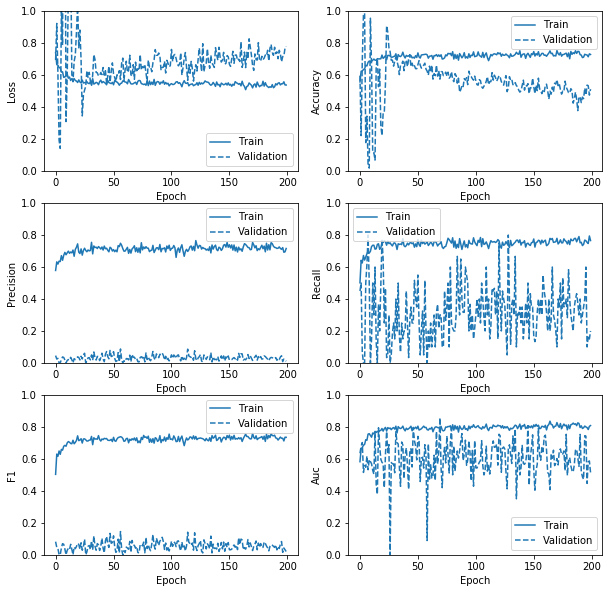

In [22]:
plt.figure(figsize=(10,10))
plot_metrics(up_history)

### Train with UP2 (1:10)

In [23]:
# start = time.time()
# up2_history = model.fit_generator(up2_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps,
#                               class_weight = [1.5,0.5],
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [24]:
# print("Time taken:",end-start)

In [25]:
# plt.figure(figsize=(10,10))
# plot_metrics(up2_history)

### Train with UP3 (1:20)

In [27]:
start = time.time()
up3_history = model.fit_generator(up3_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              class_weight = {0:0.5,1:3},
                              callbacks=[reduce_lr]
                             )
end = time.time()

Epoch 1/200
50/50 [==============================] - 21s 410ms/step - loss: 0.4083 - Accuracy: 0.5537 - Precision: 0.0688 - Recall: 0.6983 - F1: 0.1226 - AUC: 0.7798 - val_loss: 0.7706 - val_Accuracy: 0.4375 - val_Precision: 0.0471 - val_Recall: 0.4333 - val_F1: 0.0835 - val_AUC: 0.5514
Epoch 2/200
50/50 [==============================] - 20s 397ms/step - loss: 0.4123 - Accuracy: 0.5675 - Precision: 0.0990 - Recall: 0.7150 - F1: 0.1690 - AUC: 0.7753 - val_loss: 0.7750 - val_Accuracy: 0.4313 - val_Precision: 0.0267 - val_Recall: 0.3833 - val_F1: 0.0493 - val_AUC: 0.5195
Epoch 3/200
50/50 [==============================] - 23s 454ms/step - loss: 0.3914 - Accuracy: 0.5981 - Precision: 0.0897 - Recall: 0.6660 - F1: 0.1537 - AUC: 0.7814 - val_loss: 0.8776 - val_Accuracy: 0.3750 - val_Precision: 0.0099 - val_Recall: 0.2000 - val_F1: 0.0188 - val_AUC: 0.4905
Epoch 4/200
50/50 [==============================] - 20s 405ms/step - loss: 0.3820 - Accuracy: 0.5987 - Precision: 0.0805 - Recall: 0.58

50/50 [==============================] - 23s 462ms/step - loss: 0.2949 - Accuracy: 0.8256 - Precision: 0.1591 - Recall: 0.4433 - F1: 0.2221 - AUC: 0.8015 - val_loss: 0.5842 - val_Accuracy: 0.7281 - val_Precision: 0.0441 - val_Recall: 0.3500 - val_F1: 0.0771 - val_AUC: 0.7109
Epoch 30/200
50/50 [==============================] - 20s 396ms/step - loss: 0.2952 - Accuracy: 0.8425 - Precision: 0.1526 - Recall: 0.4577 - F1: 0.2139 - AUC: 0.7771 - val_loss: 0.5962 - val_Accuracy: 0.6844 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.3152
Epoch 31/200
50/50 [==============================] - 24s 479ms/step - loss: 0.2725 - Accuracy: 0.8394 - Precision: 0.1391 - Recall: 0.4917 - F1: 0.2071 - AUC: 0.8223 - val_loss: 0.6914 - val_Accuracy: 0.6094 - val_Precision: 0.0338 - val_Recall: 0.2333 - val_F1: 0.0560 - val_AUC: 0.5631
Epoch 32/200
50/50 [==============================] - 20s 395ms/step - loss: 0.2744 - Accuracy: 0.8512 - Precision: 0.1567 - Recall: 0

50/50 [==============================] - 24s 481ms/step - loss: 0.2723 - Accuracy: 0.9062 - Precision: 0.2067 - Recall: 0.3067 - F1: 0.2228 - AUC: 0.7969 - val_loss: 0.5042 - val_Accuracy: 0.8344 - val_Precision: 0.0397 - val_Recall: 0.2000 - val_F1: 0.0644 - val_AUC: 0.5377
Epoch 58/200
50/50 [==============================] - 20s 400ms/step - loss: 0.2732 - Accuracy: 0.9106 - Precision: 0.2217 - Recall: 0.3293 - F1: 0.2427 - AUC: 0.8214 - val_loss: 0.5353 - val_Accuracy: 0.8656 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4663
Epoch 59/200
50/50 [==============================] - 20s 408ms/step - loss: 0.2671 - Accuracy: 0.9000 - Precision: 0.2153 - Recall: 0.3053 - F1: 0.2355 - AUC: 0.8139 - val_loss: 0.5068 - val_Accuracy: 0.8469 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.3752
Epoch 60/200
50/50 [==============================] - 23s 470ms/step - loss: 0.2592 - Accuracy: 0.9162 - Precision: 0.1430

50/50 [==============================] - 24s 480ms/step - loss: 0.2426 - Accuracy: 0.9356 - Precision: 0.2607 - Recall: 0.3017 - F1: 0.2591 - AUC: 0.8278 - val_loss: 0.4758 - val_Accuracy: 0.8781 - val_Precision: 0.0450 - val_Recall: 0.1000 - val_F1: 0.0619 - val_AUC: 0.7412
Epoch 86/200
50/50 [==============================] - 20s 395ms/step - loss: 0.2713 - Accuracy: 0.9256 - Precision: 0.3083 - Recall: 0.2550 - F1: 0.2616 - AUC: 0.8246 - val_loss: 0.4222 - val_Accuracy: 0.9031 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4860
Epoch 87/200
50/50 [==============================] - 20s 396ms/step - loss: 0.2904 - Accuracy: 0.9156 - Precision: 0.2523 - Recall: 0.2303 - F1: 0.2157 - AUC: 0.8166 - val_loss: 0.4779 - val_Accuracy: 0.8906 - val_Precision: 0.0583 - val_Recall: 0.1000 - val_F1: 0.0733 - val_AUC: 0.4939
Epoch 88/200
50/50 [==============================] - 24s 483ms/step - loss: 0.2464 - Accuracy: 0.9262 - Precision: 0.1363 - Recall: 0

Epoch 113/200
50/50 [==============================] - 24s 480ms/step - loss: 0.2793 - Accuracy: 0.9281 - Precision: 0.2917 - Recall: 0.2323 - F1: 0.2488 - AUC: 0.8099 - val_loss: 0.4426 - val_Accuracy: 0.8938 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4198
Epoch 114/200
50/50 [==============================] - 20s 391ms/step - loss: 0.2605 - Accuracy: 0.9144 - Precision: 0.1473 - Recall: 0.2200 - F1: 0.1637 - AUC: 0.8079 - val_loss: 0.4339 - val_Accuracy: 0.9031 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4722
Epoch 115/200
50/50 [==============================] - 20s 397ms/step - loss: 0.2907 - Accuracy: 0.9206 - Precision: 0.2083 - Recall: 0.2067 - F1: 0.1947 - AUC: 0.7771 - val_loss: 0.4463 - val_Accuracy: 0.9062 - val_Precision: 0.1533 - val_Recall: 0.3250 - val_F1: 0.1794 - val_AUC: 0.7434
Epoch 116/200
50/50 [==============================] - 24s 471ms/step - loss: 0.2494 - Accuracy: 0.9306 - 

Epoch 141/200
50/50 [==============================] - 24s 477ms/step - loss: 0.2489 - Accuracy: 0.9319 - Precision: 0.2833 - Recall: 0.2867 - F1: 0.2578 - AUC: 0.8414 - val_loss: 0.4811 - val_Accuracy: 0.9125 - val_Precision: 0.0333 - val_Recall: 0.1000 - val_F1: 0.0500 - val_AUC: 0.4058
Epoch 142/200
50/50 [==============================] - 20s 401ms/step - loss: 0.2651 - Accuracy: 0.9287 - Precision: 0.2517 - Recall: 0.2433 - F1: 0.2247 - AUC: 0.8370 - val_loss: 0.3922 - val_Accuracy: 0.9156 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4897
Epoch 143/200
50/50 [==============================] - 21s 412ms/step - loss: 0.2215 - Accuracy: 0.9375 - Precision: 0.1957 - Recall: 0.2183 - F1: 0.1816 - AUC: 0.8844 - val_loss: 0.4625 - val_Accuracy: 0.9000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5993
Epoch 144/200
50/50 [==============================] - 24s 475ms/step - loss: 0.2508 - Accuracy: 0.9394 - 

Epoch 169/200
50/50 [==============================] - 24s 479ms/step - loss: 0.2443 - Accuracy: 0.9256 - Precision: 0.1683 - Recall: 0.1750 - F1: 0.1544 - AUC: 0.8194 - val_loss: 0.3591 - val_Accuracy: 0.9312 - val_Precision: 0.1500 - val_Recall: 0.1500 - val_F1: 0.1333 - val_AUC: 0.8369
Epoch 170/200
50/50 [==============================] - 20s 396ms/step - loss: 0.2418 - Accuracy: 0.9362 - Precision: 0.2800 - Recall: 0.2917 - F1: 0.2580 - AUC: 0.8295 - val_loss: 0.4696 - val_Accuracy: 0.9375 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7398
Epoch 171/200
50/50 [==============================] - 20s 403ms/step - loss: 0.2650 - Accuracy: 0.9356 - Precision: 0.2383 - Recall: 0.2267 - F1: 0.2087 - AUC: 0.7874 - val_loss: 0.3902 - val_Accuracy: 0.9406 - val_Precision: 0.0250 - val_Recall: 0.1000 - val_F1: 0.0400 - val_AUC: 0.5700
Epoch 172/200
50/50 [==============================] - 24s 481ms/step - loss: 0.2755 - Accuracy: 0.9272 - Precision: 0

50/50 [==============================] - 20s 391ms/step - loss: 0.2699 - Accuracy: 0.9294 - Precision: 0.2667 - Recall: 0.2550 - F1: 0.2445 - AUC: 0.8253 - val_loss: 0.3361 - val_Accuracy: 0.9500 - val_Precision: 0.0500 - val_Recall: 0.0500 - val_F1: 0.0500 - val_AUC: 0.6821
Epoch 197/200
50/50 [==============================] - 21s 413ms/step - loss: 0.2536 - Accuracy: 0.9294 - Precision: 0.1313 - Recall: 0.1617 - F1: 0.1333 - AUC: 0.7870 - val_loss: 0.3470 - val_Accuracy: 0.9531 - val_Precision: 0.1000 - val_Recall: 0.1000 - val_F1: 0.1000 - val_AUC: 0.5587
Epoch 198/200
50/50 [==============================] - 23s 461ms/step - loss: 0.2448 - Accuracy: 0.9219 - Precision: 0.1517 - Recall: 0.1350 - F1: 0.1302 - AUC: 0.8515 - val_loss: 0.3826 - val_Accuracy: 0.9281 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6245
Epoch 199/200
50/50 [==============================] - 20s 392ms/step - loss: 0.2488 - Accuracy: 0.9231 - Precision: 0.1817 - Recall

In [28]:
print("Time taken:",end-start)

Time taken: 4272.402341842651


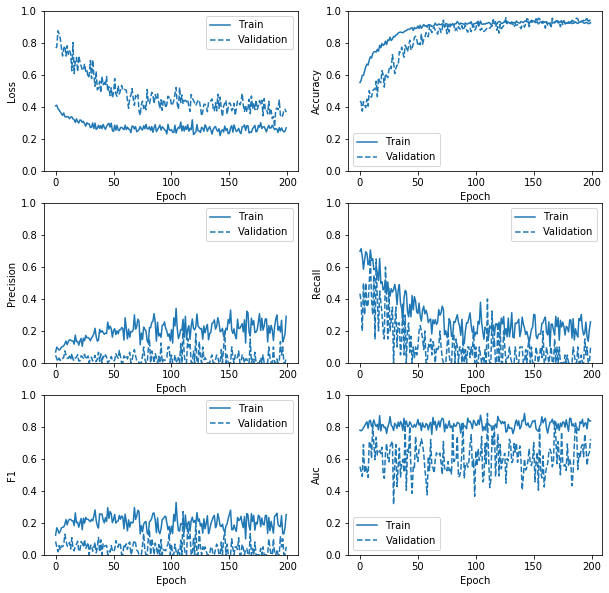

In [29]:
plt.figure(figsize=(10,10))
plot_metrics(up3_history)

### Train with UP4 (1:30)

In [ ]:
# start = time.time()
# up4_history = model.fit_generator(up4_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps, 
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [ ]:
# print("Time taken:",end-start)

In [ ]:
# plt.figure(figsize=(10,10))
# plot_metrics(up4_history)

### Train with Imbalanced original train data (1:40)

In [30]:
start = time.time()
imb_history = model.fit_generator(imb_train_generator,
                                  epochs=n_epochs,
                                  steps_per_epoch=n_steps_per_epoch,
                                  validation_data=validation_generator,
                                  validation_steps=n_validation_steps,
                                  class_weight = {0:0.2,1:5},
                                  callbacks=[reduce_lr]
                                 )
end = time.time()

Epoch 1/200
50/50 [==============================] - 20s 401ms/step - loss: 0.1545 - Accuracy: 0.9419 - Precision: 0.0667 - Recall: 0.1200 - F1: 0.0780 - AUC: 0.8696 - val_loss: 0.3959 - val_Accuracy: 0.9062 - val_Precision: 0.0500 - val_Recall: 0.0333 - val_F1: 0.0400 - val_AUC: 0.4293
Epoch 2/200
50/50 [==============================] - 19s 386ms/step - loss: 0.1626 - Accuracy: 0.9362 - Precision: 0.0933 - Recall: 0.1100 - F1: 0.0941 - AUC: 0.8226 - val_loss: 0.3837 - val_Accuracy: 0.9125 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5092
Epoch 3/200
50/50 [==============================] - 24s 484ms/step - loss: 0.1553 - Accuracy: 0.9431 - Precision: 0.1017 - Recall: 0.1500 - F1: 0.1167 - AUC: 0.7514 - val_loss: 0.3815 - val_Accuracy: 0.9062 - val_Precision: 0.0250 - val_Recall: 0.0333 - val_F1: 0.0286 - val_AUC: 0.7035
Epoch 4/200
50/50 [==============================] - 18s 370ms/step - loss: 0.1794 - Accuracy: 0.9356 - Precision: 0.1747 - 

Epoch 29/200
50/50 [==============================] - 20s 400ms/step - loss: 0.1783 - Accuracy: 0.9050 - Precision: 0.1047 - Recall: 0.2050 - F1: 0.1278 - AUC: 0.8189 - val_loss: 0.3966 - val_Accuracy: 0.9187 - val_Precision: 0.0700 - val_Recall: 0.2000 - val_F1: 0.1000 - val_AUC: 0.6839
Epoch 30/200
50/50 [==============================] - 22s 435ms/step - loss: 0.1199 - Accuracy: 0.9162 - Precision: 0.1170 - Recall: 0.2283 - F1: 0.1459 - AUC: 0.8893 - val_loss: 0.4495 - val_Accuracy: 0.9031 - val_Precision: 0.0500 - val_Recall: 0.0333 - val_F1: 0.0400 - val_AUC: 0.7117
Epoch 31/200
50/50 [==============================] - 19s 390ms/step - loss: 0.1651 - Accuracy: 0.9187 - Precision: 0.1217 - Recall: 0.2400 - F1: 0.1533 - AUC: 0.7826 - val_loss: 0.4216 - val_Accuracy: 0.9031 - val_Precision: 0.0250 - val_Recall: 0.1000 - val_F1: 0.0400 - val_AUC: 0.6048
Epoch 32/200
50/50 [==============================] - 20s 406ms/step - loss: 0.1886 - Accuracy: 0.9112 - Precision: 0.1510 - Recall: 

50/50 [==============================] - 20s 399ms/step - loss: 0.1620 - Accuracy: 0.8831 - Precision: 0.0735 - Recall: 0.1833 - F1: 0.0944 - AUC: 0.8011 - val_loss: 0.4882 - val_Accuracy: 0.8625 - val_Precision: 0.0500 - val_Recall: 0.1000 - val_F1: 0.0667 - val_AUC: 0.5606
Epoch 58/200
50/50 [==============================] - 20s 407ms/step - loss: 0.1509 - Accuracy: 0.8925 - Precision: 0.0602 - Recall: 0.1667 - F1: 0.0857 - AUC: 0.7882 - val_loss: 0.4841 - val_Accuracy: 0.8594 - val_Precision: 0.0533 - val_Recall: 0.1000 - val_F1: 0.0686 - val_AUC: 0.6583
Epoch 59/200
50/50 [==============================] - 22s 436ms/step - loss: 0.1303 - Accuracy: 0.8944 - Precision: 0.0890 - Recall: 0.2400 - F1: 0.1252 - AUC: 0.8376 - val_loss: 0.5236 - val_Accuracy: 0.8406 - val_Precision: 0.0200 - val_Recall: 0.0500 - val_F1: 0.0286 - val_AUC: 0.6053
Epoch 60/200
50/50 [==============================] - 20s 406ms/step - loss: 0.1451 - Accuracy: 0.8813 - Precision: 0.0823 - Recall: 0.1700 - F1: 

50/50 [==============================] - 20s 409ms/step - loss: 0.1651 - Accuracy: 0.8712 - Precision: 0.0719 - Recall: 0.2000 - F1: 0.0981 - AUC: 0.7810 - val_loss: 0.4138 - val_Accuracy: 0.8906 - val_Precision: 0.0167 - val_Recall: 0.1000 - val_F1: 0.0286 - val_AUC: 0.5397
Epoch 86/200
50/50 [==============================] - 18s 369ms/step - loss: 0.1720 - Accuracy: 0.8750 - Precision: 0.0954 - Recall: 0.2433 - F1: 0.1295 - AUC: 0.8173 - val_loss: 0.3862 - val_Accuracy: 0.8875 - val_Precision: 0.0783 - val_Recall: 0.1333 - val_F1: 0.0971 - val_AUC: 0.6806
Epoch 87/200
50/50 [==============================] - 19s 384ms/step - loss: 0.1566 - Accuracy: 0.8706 - Precision: 0.1165 - Recall: 0.2900 - F1: 0.1455 - AUC: 0.8419 - val_loss: 0.4523 - val_Accuracy: 0.9000 - val_Precision: 0.1367 - val_Recall: 0.3500 - val_F1: 0.1900 - val_AUC: 0.7065
Epoch 88/200
50/50 [==============================] - 20s 404ms/step - loss: 0.1791 - Accuracy: 0.8756 - Precision: 0.0907 - Recall: 0.2533 - F1: 

50/50 [==============================] - 20s 399ms/step - loss: 0.1844 - Accuracy: 0.8594 - Precision: 0.0850 - Recall: 0.2567 - F1: 0.1210 - AUC: 0.7704 - val_loss: 0.4487 - val_Accuracy: 0.8562 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.3502
Epoch 114/200
50/50 [==============================] - 18s 364ms/step - loss: 0.1653 - Accuracy: 0.8706 - Precision: 0.0814 - Recall: 0.2467 - F1: 0.1176 - AUC: 0.7741 - val_loss: 0.5401 - val_Accuracy: 0.8750 - val_Precision: 0.0593 - val_Recall: 0.3000 - val_F1: 0.0983 - val_AUC: 0.7747
Epoch 115/200
50/50 [==============================] - 19s 383ms/step - loss: 0.1691 - Accuracy: 0.8650 - Precision: 0.0960 - Recall: 0.3233 - F1: 0.1432 - AUC: 0.8344 - val_loss: 0.4774 - val_Accuracy: 0.8687 - val_Precision: 0.0367 - val_Recall: 0.1500 - val_F1: 0.0571 - val_AUC: 0.6256
Epoch 116/200
50/50 [==============================] - 20s 407ms/step - loss: 0.1910 - Accuracy: 0.8587 - Precision: 0.1377 - Recall

50/50 [==============================] - 17s 348ms/step - loss: 0.1493 - Accuracy: 0.8562 - Precision: 0.1074 - Recall: 0.4100 - F1: 0.1662 - AUC: 0.8460 - val_loss: 0.4919 - val_Accuracy: 0.8000 - val_Precision: 0.0333 - val_Recall: 0.1333 - val_F1: 0.0508 - val_AUC: 0.7906
Epoch 142/200
50/50 [==============================] - 18s 355ms/step - loss: 0.1435 - Accuracy: 0.8600 - Precision: 0.1041 - Recall: 0.2633 - F1: 0.1373 - AUC: 0.8341 - val_loss: 0.5190 - val_Accuracy: 0.8406 - val_Precision: 0.0254 - val_Recall: 0.1500 - val_F1: 0.0422 - val_AUC: 0.6582
Epoch 143/200
50/50 [==============================] - 18s 352ms/step - loss: 0.2065 - Accuracy: 0.8575 - Precision: 0.1271 - Recall: 0.4067 - F1: 0.1829 - AUC: 0.7865 - val_loss: 0.5078 - val_Accuracy: 0.8656 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4929
Epoch 144/200
50/50 [==============================] - 18s 354ms/step - loss: 0.1731 - Accuracy: 0.8594 - Precision: 0.1124 - Recall

Epoch 169/200
50/50 [==============================] - 18s 359ms/step - loss: 0.1395 - Accuracy: 0.8581 - Precision: 0.0800 - Recall: 0.2833 - F1: 0.1193 - AUC: 0.8250 - val_loss: 0.5438 - val_Accuracy: 0.8156 - val_Precision: 0.0200 - val_Recall: 0.0500 - val_F1: 0.0286 - val_AUC: 0.6714
Epoch 170/200
50/50 [==============================] - 17s 338ms/step - loss: 0.1662 - Accuracy: 0.8656 - Precision: 0.0912 - Recall: 0.2717 - F1: 0.1279 - AUC: 0.7877 - val_loss: 0.3919 - val_Accuracy: 0.8375 - val_Precision: 0.0458 - val_Recall: 0.1500 - val_F1: 0.0700 - val_AUC: 0.5713
Epoch 171/200
50/50 [==============================] - 17s 346ms/step - loss: 0.1425 - Accuracy: 0.8600 - Precision: 0.0704 - Recall: 0.2600 - F1: 0.1066 - AUC: 0.8156 - val_loss: 0.4884 - val_Accuracy: 0.8344 - val_Precision: 0.0533 - val_Recall: 0.2500 - val_F1: 0.0857 - val_AUC: 0.6913
Epoch 172/200
50/50 [==============================] - 18s 355ms/step - loss: 0.1822 - Accuracy: 0.8562 - Precision: 0.1044 - Reca

50/50 [==============================] - 18s 357ms/step - loss: 0.1524 - Accuracy: 0.8650 - Precision: 0.0938 - Recall: 0.2787 - F1: 0.1302 - AUC: 0.8341 - val_loss: 0.5332 - val_Accuracy: 0.8531 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6046
Epoch 198/200
50/50 [==============================] - 17s 348ms/step - loss: 0.1848 - Accuracy: 0.8525 - Precision: 0.0992 - Recall: 0.2833 - F1: 0.1349 - AUC: 0.7817 - val_loss: 0.4526 - val_Accuracy: 0.8219 - val_Precision: 0.0867 - val_Recall: 0.3000 - val_F1: 0.1321 - val_AUC: 0.7185
Epoch 199/200
50/50 [==============================] - 18s 355ms/step - loss: 0.1488 - Accuracy: 0.8525 - Precision: 0.0692 - Recall: 0.2500 - F1: 0.1053 - AUC: 0.7994 - val_loss: 0.5163 - val_Accuracy: 0.8219 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4043
Epoch 200/200
50/50 [==============================] - 18s 365ms/step - loss: 0.1959 - Accuracy: 0.8581 - Precision: 0.1

In [31]:
print("Time taken:",end-start)

Time taken: 3844.446877479553


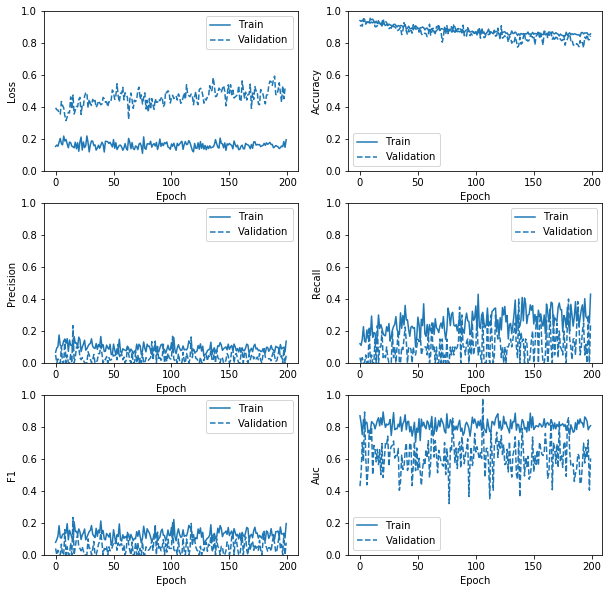

In [32]:
plt.figure(figsize=(10,10))
plot_metrics(imb_history)

## Evaluation

In [33]:
results_tr = model.evaluate(imb_train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 11s 114ms/step


In [34]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))

# without classweights:
# NAME :	TRAIN :	VALIDATION 
# loss : 0.754 :   0.465
# Accuracy : 0.531 :   0.866
# Precision : 0.006 :   0.006
# Recall : 0.070 :   0.040
# F1 : 0.011 :   0.010
# AUC : 0.565 :   0.544

NAME :	TRAIN :	VALIDATION 
loss : 0.571 :   0.440
Accuracy : 0.766 :   0.826
Precision : 0.022 :   0.030
Recall : 0.142 :   0.134
F1 : 0.038 :   0.046
AUC : 0.562 :   0.611


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [35]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(imb_train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(1149.4737193584442, 204.47840547561646)

In [ ]:
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newtr.npy', pred_tr)
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newvl.npy', pred_vl)

In [ ]:
# val_class = []
# for i, predicted in enumerate(pred_vl):
#     if predicted[0] > 0.1:
#         #assign i to class 1
#         val_class.append(1)
#     else:
#         #assign i to class 0
#         val_class.append(0)

In [36]:
# TRUE LABELS

train_labels = valid_traindf_names[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


### ROC Curve

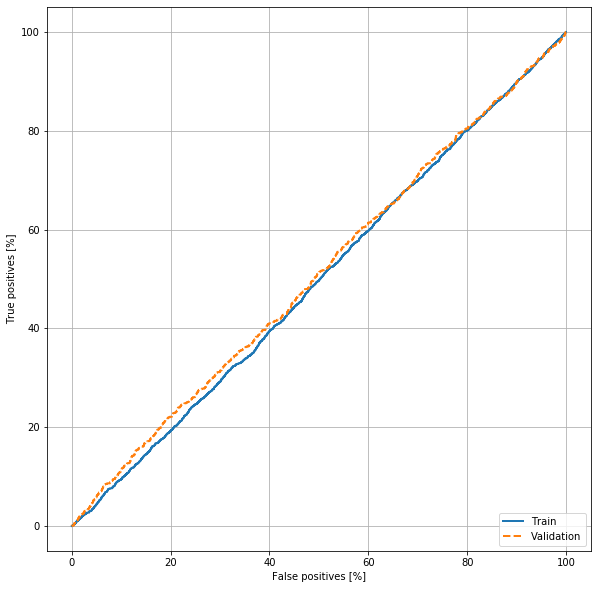

In [37]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
# plot_roc("Validation", val_labels, val_class, color=colors[3],linestyle='-.') # theshold 0.1
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 77078 
FP: 22377 
FN: 1860 
TP: 519
Healthy Patients - correctly identified (True Negatives):  77078 0.7750037705494948
Healthy Patients - predicted to have glaucoma (False Positives):  22377 0.22499622945050526
Glaucoma Patients - predicted healthy (False Negatives):  1860 0.7818411097099621
Glaucoma Patients - correctly identified (True Positives):  519 0.21815889029003782

Total Glaucoma patients:  2379 1.0
Total Healthy patients:  99455 1.0


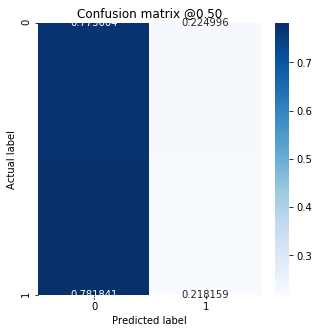

In [38]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 27731 
FP: 5403 
FN: 664 
TP: 145
Healthy Patients - correctly identified (True Negatives):  27731 0.836934870525744
Healthy Patients - predicted to have glaucoma (False Positives):  5403 0.16306512947425605
Glaucoma Patients - predicted healthy (False Negatives):  664 0.8207663782447466
Glaucoma Patients - correctly identified (True Positives):  145 0.1792336217552534

Total Glaucoma patients:  809 1.0
Total Healthy patients:  33134 1.0


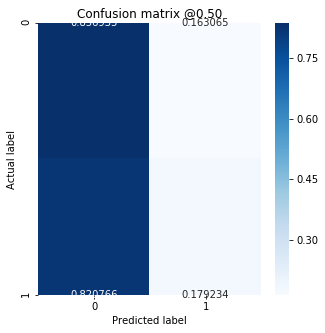

In [39]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

### MLFlow 

In [ ]:
# history = up3_history
# tag_value = "trained twice bal and 1:20 and 1:40 with 78 tr layers with cw 0.5:3 and 0.2:5"

# exp_name = get_notebook_name()+"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
# keras_model_path = funduspath_CR+ exp_name + '_model'
# save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
#             n_epochs,n_steps_per_epoch,n_validation_steps,
#             reg_value,learning_rate,decay,opt,
#             history,results_tr,results_vl,train_cm,val_cm
#            )

In [ ]:
# client = MlflowClient()
# run = client.create_run('21')
# client.set_tag(run.info.run_id, "tag_key", tag_value)